# Garbage Classification using Resnet 50 

### Description:  
This project is aimed to develop a garbage classification system using the ResNet50 architecture. The primary dataset serves as a foundation for building models that can eventually **automate waste segregation**, a critical step in **optimizing recycling** and **waste management**, ultimately aiding in **environmental conservation**. A notable challenge encountered is the *inherent class imbalance* within the dataset, prompting the exploration of *data augmentation*, and varied evaluation metrics. This project journey encompasses a comprehensive dataset analysis, addresses the imbalance, and delves deep into building and evaluating model through transfer learning with ResNet50.

### Objectives:  
- Dataset Exploration: Dive into the garbage dataset, emphasizing class imbalances.  
- Tackle Imbalance: Utilize class weights in the loss function to address dataset disparities.  
- Implement Data Augmentation: Enhance model generalization and combat overfitting.  
<!-- - Construct ResNet50: Design a custom ResNet50 for garbage classification from scratch.   -->
- Employ Transfer Learning: Leverage a pre-trained ResNet50, adapting it for our specific dataset.  
- Evaluate Models: Assess model's performance using varied metrics (Learning Curves, Performance Matrix & Confusion Matrix) to ensure reliable classification.

### Table of Contents:  
- Step 1 | Setup and Initialization (installing libraries)  
- Step 2 | Dataset Analysis  
- Step 3 | Dataset Preparation  
    * Step 3.1 | Centralize Dataset Information  
    * Step 3.2 | Stratified Data Splitting: Train & Validation  
    * Step 3.3 | Data Augmentation & Rescaling  
    * Step 3.4 | Generating Batches of Images  
- Step 4 | Addressing Dataset Imbalances  
- Step 5 | ResNet50 with Transfer Learning  
    * Step 5.1 | Loading ResNet50 with Pre-trained Weights, Freezing and Adding our custom Layers  
    * Step 5.2 | Applying ResNet50-specific Image Preprocessing  
    * Step 5.3 | Fine-tuning the Transfer Learning ResNet50 Model  
    * Step 5.4 | Evaluating the Transfer Learning ResNet50 Model  

## Step 1: Setup and Initialisation

In [5]:
import warnings
warnings.filterwarnings('ignore')

import os #file handling
import numpy as np #arrays
import pandas as pd #dataframe
import seaborn as sns #charts / data visualisation
import matplotlib.pyplot as plt #charts / data visualisation
from matplotlib.colors import LinearSegmentedColormap 
from PIL import Image #image processing / to open and edit pics
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight #to balance data / handle uneven classes
from tensorflow.keras.preprocessing.image import ImageDataGenerator #image augmentation / creates more training images by slightly changing existing ones
from tensorflow.keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout #NN builduing blocks
from tensorflow.keras.applications import ResNet50 #pre-trained CNN model (image recognition)
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam #helps the model learn faster and better
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint #training control-to avoid overfitting
from tensorflow.keras.models import Model #model creation
from tensorflow.keras.utils import plot_model #model visualisation
from sklearn.metrics import classification_report, confusion_matrix #evaluation metrics

2025-11-21 14:59:34.835000: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763737175.044321      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763737175.100341      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [6]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

In [7]:
# !pip install protobuf==4.25.3 --force-reinstall --no-cache-dir

## Step 2: Dataset Analysis

Now, taking a look inside the different folders of the dataset containing different garbage types. For each garbage type, count its pictures and check if they all have the same size. Then, display these details for every garbage type:

In [8]:
# Define the path where our dataset is stored
dataset_path = '/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types: #loop over folders
    folder_path = os.path.join(dataset_path, garbage_type)
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]
        
        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")
        
        # Loop over each image to check its dimensions
        for image_file in image_files: #going through each image one-by-one
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))
                
# Determine if all images in the entire dataset have the same dimensions 
if len(all_dimensions_set) == 1:  #if there’s only one unique size across all images
    width, height, channel = all_dimensions_set.pop()  #take that single (w,h,channels) value out to use it
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

metal folder contains 410 images.
glass folder contains 501 images.
paper folder contains 594 images.
trash folder contains 137 images.
cardboard folder contains 403 images.
plastic folder contains 482 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


### Handling Class Imbalance:

The "Garbage Image Dataset" reveals a noticeable imbalance in the distribution of its image categories:

- **metal**: 410 images
- **glass**: 501 images
- **paper**: 594 images
- **trash**: 137 images
- **cardboard**: 403 images
- **plastic**: 482 images

This can lead to: **Bias, Generalization Issues & Accuracy Deception.**

To create an efficient classifier, addressing this imbalance is crucial.

Exploring the images from each garbage category:

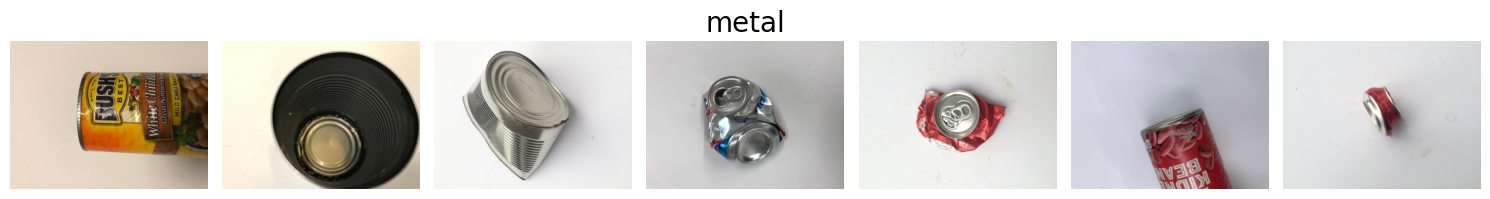

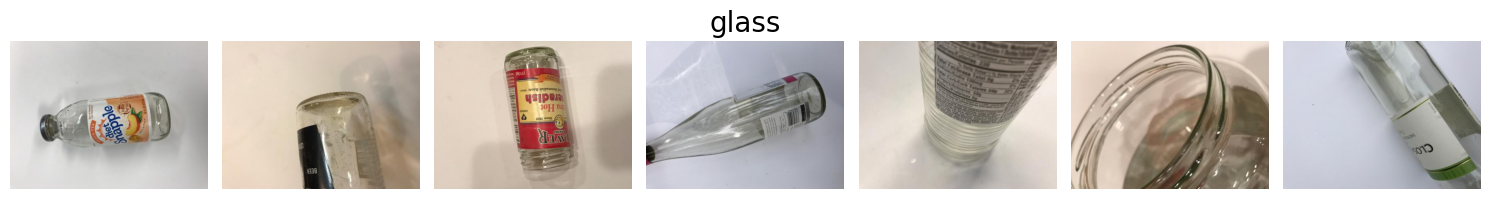

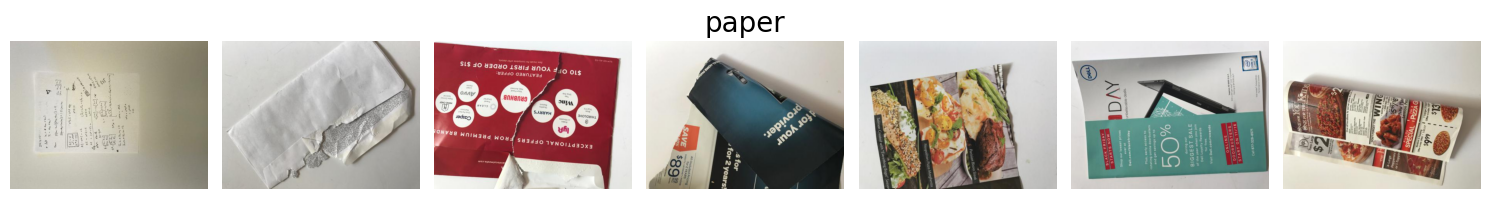

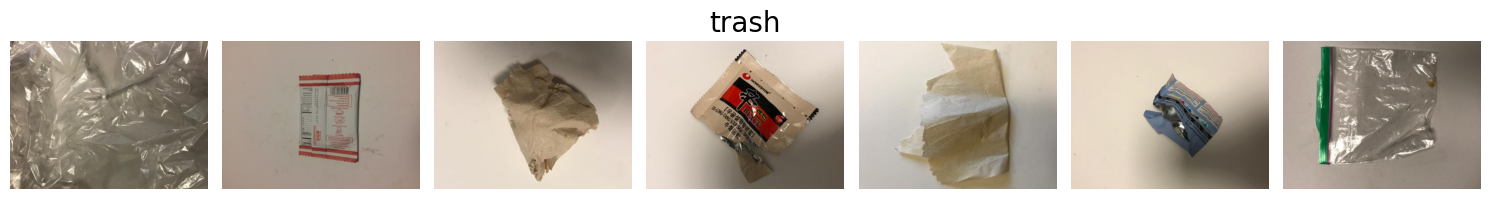

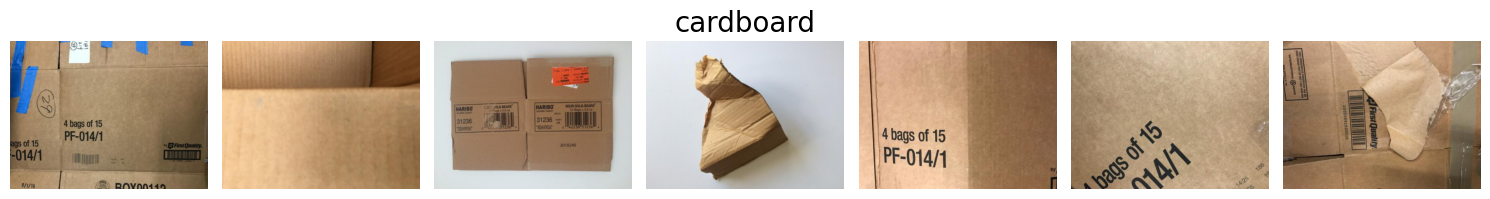

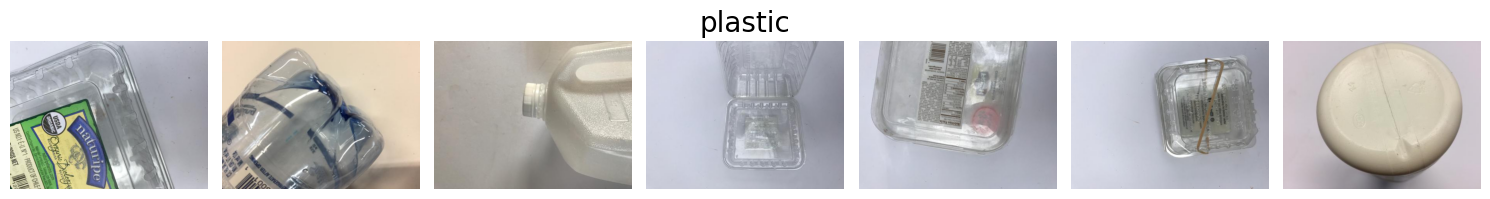

In [9]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types: #go through each trash folder one by one.
    folder_path = os.path.join(dataset_path, garbage_type) #create the full folder path.
    
    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))] #pick only JPG/JPEG images inside that folder.
        
        # Select the first 7 images
        image_files = image_files[:7] #slicing
        
        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2)) #7 spots in 1 row
        
        for i, image_file in enumerate(image_files): #go through each image and know its position (index)
            image_path = os.path.join(folder_path, image_file) #create full path for the current image
            with Image.open(image_path) as img: #open the image so it auto-closes after use.
                axs[i].imshow(img) #show image in its subplot
                axs[i].axis('off') #hide axes or remove borders and ticks around the image
        
        plt.tight_layout() #neatly arrange all images without overlap.
        fig.suptitle(garbage_type, fontsize=20, y=1.03) #show the folder name above the images
        plt.show() #render

## Step 3: Dataset Preparation

## Step 3.1 Centralize Dataset Information

Since, all the images scattered across multiple folders, one for each garbage class. We need a unified view of the data for easy manipulation.

**Approach:** Create a DataFrame that contains file paths and corresponding labels.

In [10]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types: #go through each garbage folder
    for file in os.listdir(os.path.join(dataset_path, garbage_type)): #go through every file inside that folder.
        # Append the image file path and its trash type (as a label) to the data list
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath  label
0  /kaggle/input/trash-type-image-dataset/TrashTy...  metal
1  /kaggle/input/trash-type-image-dataset/TrashTy...  metal
2  /kaggle/input/trash-type-image-dataset/TrashTy...  metal
3  /kaggle/input/trash-type-image-dataset/TrashTy...  metal
4  /kaggle/input/trash-type-image-dataset/TrashTy...  metal

## Step 3.2: Stratified Data Splitting: Training & Validation

To ensure our train and validation sets represent **all garbage classes** well, and to avoid potential biases associated with the order of images, we need the sets to have a **similar distribution of classes** as the whole dataset and also be **shuffled**.  

**Approach:**
Employed stratified sampling through `train_test_split`, which inherently **shuffles** and **divides** the DataFrame while **maintaining a consistent distribution of classes**.

In [11]:
# Split with stratification (ordered)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label']) #divides data — 80% for training, 20% for validation, keeping same class ratio(balance) in both sets.

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")


Number of images in the training set: 2021
Number of images in the validation set: 506


Let's verify that the distributions in the training and validation sets closely mirror the overall distribution:

In [12]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100 #calculates what percent of each trash type is in the full dataset.

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40) #separator-print a line for clarity.

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


#### Inference on Stratification Effectiveness:
The class distributions in both the training and validation sets closely mirror the overall distribution in the entire dataset, indicating that **stratification during the split was successful.**

## Step 3.3: Data Augmentation & Rescaling (to avoid Overfitting):

- We have limited images (2527), so we risk overfitting.
- Neural networks work better with input values between 0 and 1, but our images have pixel values between 0 and 255.

**Approach:**
- Augment the training images to artificially increase dataset size.
- Rescale both training and validation images for better network performance.

#### Note on Data Augmentation in Validation Set:
__Data augmentation__ is a technique primarily used to expand the training dataset in order to improve the model's capacity to generalize and avoid overfitting.  
***The primary objective is to introduce variability and mimic potential real-world distortions in the training images without actually collecting more data.***

On the other hand, the validation set's role is to provide an unbiased evaluation of a model's performance on unseen data. Thus, we want the validation data to remain consistent throughout the model's training process to ensure that our evaluations are stable and reproducible. Applying augmentations to the validation set would introduce random variability in the evaluation metrics across different epochs, making it harder to determine whether changes in the model's performance are due to the model's learning or just the variability introduced by augmentations.

Therefore, to maintain a consistent and clear evaluation benchmark, I ***refrain from applying data augmentation to the validation set, using only rescaling to ensure the pixel values are in a similar range as the augmented training images.***

### Designing Data Augmentation for Garbage Classification:
Based on the dataset, here are some observations regarding the potential data augmentation techniques:

### Suitable Transformations:
- __Rescaling__: Necessary to normalize pixel values between 0 and 1.
- __Rotation__: Captures objects in various orientations.
- __Width and Height Shift__: Models minor positional changes.
- __Zoom__: Simulates different object distances.
- __Flip__: Captures different horizontal or vertical orientations.
- __Shear__: Provides a skewed perspective of images.
- __Brightness Adjustment__: Adapts images to diverse lighting conditions.
- __Channel Shift__: Alters colors for added variety.
- __Fill Mode__: Addresses missing pixel values.

In [13]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator( #automatically makes new, slightly changed copies of training images (augmentation)
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations (tilt)
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

## Step 3.4: Generating Batches of Images

Issue:
- Can't load all images at once due to memory constraints.
- Want to benefit from the DataFrame format to feed our images into our model.
- Most CNN architectures often perform better with **square images**.
- Aim is to avoid manual one-hot encoding of labels.
- Ensuring **consistent ordering and reproducibility** during training.

**Approach:**
- Use the `flow_from_dataframe` method **to generate batches of images and labels directly from our DataFrame**.
- Rescale images to **384x384** to maintain a square shape, aligning with the design preferences of CNNs.
- Leverage the initial shuffling done through `train_test_split` to randomize data order, eliminating the need for additional shuffling in the generators.
- Use a **seed** (`seed=42`) during data augmentation to ensure **reproducibility** of transformations across runs.

In [14]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe WITH data augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels (categorical=multi-class classification) - labels will be converted into one-hot encoded vectors. Ex:[1,0,0]
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe WITHOUT data augmentation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [15]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


#### Understanding ImageDataGenerator:
When we create `train_generator` using `flow_from_dataframe`, we're __not__ pre-generating all batches of images with their transformations. What we are doing is setting up a framework or a "__pipeline__" that knows how to fetch and transform the images when requested.

The **benefit of ImageDataGenerator** is precisely this: it generates augmented images __on-the-fly__ during each step of each epoch. It doesn't pre-generate and store them.

When we ask for `len(train_generator)`, it's just doing a calculation based on the total number of images and the batch size to tell us how many batches there will be. It doesn't mean those batches have been pre-generated.

## Step 4: Addressing Dataset Imbalances



**Addressing Imbalance Using Class Weights:**  
To tackle our imbalanced image dataset, we'll utilize class weights. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like `compute_class_weight` from scikit-learn based on the distribution of images in each class. The formula is:

$$ \text{weight}(class) = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in that class}} $$
(If a class has very few images, the denominator becomes small → weight becomes big → model pays more attention to that class.  
If a class has many images, denominator is big → weight small → normal attention.  
Fewer images = higher weight. More images = lower weight.)

These computed weights are then passed to the model


In [16]:
# Extract class labels from the 'label' column of train_df
class_labels = train_df['label'].unique()
class_labels

array(['trash', 'glass', 'paper', 'metal', 'plastic', 'cardboard'],
      dtype=object)

In [17]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [18]:
# Compute class weights
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label']) #balanced-> using above formula, class_labels->passing unique class labels in sorted order,train_df-> list of labels for all training samples 
weights

array([3.06212121, 0.83998337, 0.70912281, 1.02693089, 0.87489177,
       1.04606625])

Rare class → higher weight  
Frequent class → lower weight

In [19]:
# Convert the computed weights to a dictionary for passing to model training
class_weights = dict(zip(train_generator.class_indices.values(), weights))
class_weights

{0: 3.062121212121212,
 1: 0.8399833748960931,
 2: 0.7091228070175438,
 3: 1.026930894308943,
 4: 0.8748917748917749,
 5: 1.0460662525879918}

**Understanding Class Label Mapping in ImageDataGenerator:**
When we create a generator using __`flow_from_dataframe`__ with the __`class_mode='categorical'`__ setting, the generator internally maps each unique class label in our `y_col` (in this case, the "label" column of __`train_df`__) to a unique integer. This mapping is done in alphabetical order, which means:

- '__cardboard__' is mapped to __0__
- '__glass__' is mapped to __1__
- '__metal__' is mapped to __2__
- '__paper__' is mapped to __3__
- '__plastic__' is mapped to __4__
- '__trash__' is mapped to __5__

This mapping is stored in the __`train_generator.class_indices`__ dictionary. Keys of this dictionary are the class labels (e.g., 'cardboard', 'glass', etc.), and the corresponding values are the mapped integers (e.g., 0, 1, etc.).

This mapping ensures that when we're using one-hot encoding, the correct position in the one-hot encoded vector corresponds to the appropriate class. For example, the one-hot encoded vector for 'cardboard' would be __`[1, 0, 0, 0, 0, 0]`__.

When we computed the __`class_weights`__, we used this mapping to ensure the weights correspond correctly to the one-hot encoded labels during training.

## Step 5: ResNet50 with Transfer Learning

## Step 5.1: Loading ResNet50 with Pre-trained Weights

First of all, load the ResNet50 architecture pre-trained on the __ImageNet dataset__. Excluding the top classifier layer to adjust for the specific 6-class classification task and set the input shape to `(384, 384, 3)` to align with our dataset's image dimensions:

In [20]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))


I0000 00:00:1763737221.926278      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Let's take a look at our `base_model` summary:

In [21]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Our `base_model` contains approximately **23.5 million** trainable parameters!

The name __ResNet50__ refers to a residual network with 50 weight layers. However, when we include other types of layers like Batch Normalization, Activation layers, etc., the total count goes up. Let's find it:

In [22]:
len(base_model.layers) 

175

### Deciding the Level of Transfer Learning (Freezing Layers of the model):

A **balanced approach** is to **freeze the earlier layers**, which capture broad and general features, and **fine-tune the latter layers**.

Intuition:
Given the structure and our objective to balance the amount of layers we freeze, the __end of Block 4__ would be optimal. This ensures that the **broad and general features from the initial blocks are retained**, while the **more specific features in the latter blocks can be fine-tuned** to our dataset. Let's print out the names of the layers around the end of Block 4 to find the precise layer name we want to freeze up to:

In [23]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

140 conv4_block6_3_bn
141 conv4_block6_add
142 conv4_block6_out
143 conv5_block1_1_conv
144 conv5_block1_1_bn
145 conv5_block1_1_relu
146 conv5_block1_2_conv
147 conv5_block1_2_bn
148 conv5_block1_2_relu
149 conv5_block1_0_conv
150 conv5_block1_3_conv


From the list provided, the end of Block 4 (conv4) is represented by __`conv4_block6_out`__, which is layer number __`142`__. Now, let's freeze the layers up to __`conv4_block6_out`__:

In [24]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

**Adding Custom Layers to the pre-trained model:**  
Now, extending the pre-trained base_model (ResNet50) by adding custom layers to tailor it for our specific classification task. After extracting features using ResNet50,    
1. __Global Average Pooling__ layer to condense the spatial dimensions.  
2. __Dropout__ layer is added for regularization, reducing the risk of overfitting.  
3. Finally, a __Dense__ layer with a softmax activation function is employed to classify the inputs into our 6 distinct classes:

In [25]:
# Create the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Architecture of our new model:

In [26]:
plot_model(transfer_resnet50_model, show_shapes=True, show_layer_names=False, dpi=200, show_dtype=False, expand_nested=False, show_layer_activations=True, show_trainable=True)

Model summary to understand the number of parameters involved:

In [27]:
transfer_resnet50_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 390, 390,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 192, 192,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 192, 192,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 192, 192,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 194, 194,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 96, 96,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 96, 96,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 96, 96,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 96, 96,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 96, 96,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 96, 96,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 96, 96,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 96, 96,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 96, 96,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 96, 96,    │      1,024 │ conv2_block1_3_c

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 14,988,294 (57.18 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

#### Reduction in Trainable Parameters After Freezing Blocks:
As observed from the model summary, after freezing the first four blocks of our ResNet architecture, the number of trainable parameters significantly reduced to approximately **15 million**, down from the **initial 23.5 million**.  
This change ensures a more balanced approach, reducing the risk of overfitting while capitalizing on the pre-trained knowledge of the model.

## Step 5.2: Applying ResNet50-specific Image Preprocessing 


**Updating Data Preprocessing for ResNet50:**  

ResNet50 was originally trained with a unique preprocessing on the __ImageNet__ dataset. Not adhering to this preprocessing can result in reduced model performance. Therefore, we'll need to modify the generators we set up in __Step 3.3__. The two key changes are:
    
- Using the `preprocess_input` of ResNet50 as the `preprocessing_function` for `ImageDataGenerator`.
- Removing the `rescale` argument from `ImageDataGenerator`, as this is already handled by `preprocess_input`.

Here's the updated approach:

In [28]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

Utilizing the above generators to produce data batches for both the training and validation phases:

In [29]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


## Step 5.3: Fine-tuning the Transfer Learning ResNet50 Model

Now, Fine-tuning our model on our garbage dataset. Employing **callbacks** to adjust the **learning rate** when needed and to halt training early (**Early Stopping**) if there's no improvement, ensuring efficient and optimal training. The model will be also trained using **class weights** to account for potential **class imbalances** in the data.

In [30]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint("best_garbage_model.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

# Total number of epochs
num_epochs = 50  

# Train the model
history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator), 
                                      epochs=num_epochs,
                                      validation_data=val_generator, 
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights, #using class weights
                                      callbacks=[reduce_lr, early_stopping, checkpoint])

Epoch 1/50


I0000 00:00:1763737246.460017     125 service.cc:148] XLA service 0x7862a0016d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763737246.460796     125 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763737248.607406     125 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/64 ━━━━━━━━━━━━━━━━━━━━ 25:15 24s/step - accuracy: 0.1562 - loss: 2.8320

I0000 00:00:1763737258.142962     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5062 - loss: 1.4178
Epoch 1: val_accuracy improved from -inf to 0.79051, saving model to best_garbage_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.5086 - loss: 1.4106 - val_accuracy: 0.7905 - val_loss: 0.6053 - learning_rate: 1.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8545 - loss: 0.3949
Epoch 2: val_accuracy improved from 0.79051 to 0.90909, saving model to best_garbage_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8549 - loss: 0.3943 - val_accuracy: 0.9091 - val_loss: 0.2718 - learning_rate: 1.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9188 - loss: 0.2356
Epoch 3: val_accuracy improved from 0.90909 to 0.91107, saving model to best_garbage_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9190 - loss: 0.2353 - val_accuracy: 0.9111 - val_loss: 0.2774 - learning_rate: 1.0000e-04
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9545 - loss: 0.1304
Epoch 4: val_accuracy improved from 0.91107 to 0.92490, saving model to best_garbage_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9545 - loss: 0.1305 - val_accuracy: 0.9249 - val_loss: 0.2817 - learning_rate: 1.0000e-04
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9593 - loss: 0.1108
Epoch 5: val_accuracy did not improve from 0.92490
64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9593 - loss: 0.1108 - val_accuracy: 0.9190 - val_loss: 0.3159 - learning_rate: 1.0000e-04
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9735 - loss: 0.0821
Epoch 6: val_accuracy improved from 0.92490 to 0.93478, saving model to best_garbage_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9736 - loss: 0.0820 - val_accuracy: 0.9348 - val_loss: 0.3719 - learning_rate: 1.0000e-04
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9822 - loss: 0.0654
Epoch 7: val_accuracy did not improve from 0.93478
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9822 - loss: 0.0654 - val_accuracy: 0.9289 - val_loss: 0.2439 - learning_rate: 1.0000e-04
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9831 - loss: 0.0585
Epoch 8: val_accuracy did not improve from 0.93478
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9831 - loss: 0.0584 - val_accuracy: 0.9308 - val_loss: 0.2974 - learning_rate: 1.0000e-04
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9779 - loss: 0.0562
Epoch 9: val_accuracy did not improve from 0.93478
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9780 - loss: 0.0562 - val_accuracy: 0.9269 - val_loss: 0.2565 - learning_rate: 1.0000e-04
Epoch 10/50
64/64 ━━━━━━━━

64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9969 - loss: 0.0170 - val_accuracy: 0.9427 - val_loss: 0.2077 - learning_rate: 1.0000e-04
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9873 - loss: 0.0319
Epoch 12: val_accuracy improved from 0.94269 to 0.94862, saving model to best_garbage_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.9873 - loss: 0.0318 - val_accuracy: 0.9486 - val_loss: 0.1755 - learning_rate: 1.0000e-04
Epoch 13/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9950 - loss: 0.0261
Epoch 13: val_accuracy did not improve from 0.94862
64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9949 - loss: 0.0262 - val_accuracy: 0.9486 - val_loss: 0.2062 - learning_rate: 1.0000e-04
Epoch 14/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9948 - loss: 0.0225
Epoch 14: val_accuracy did not improve from 0.94862
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9947 - loss: 0.0226 - val_accuracy: 0.9407 - val_loss: 0.2282 - learning_rate: 1.0000e-04
Epoch 15/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9878 - loss: 0.0491
Epoch 15: val_accuracy improved from 0.94862 to 0.95059, saving model to best_garbage_model.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9878 - loss: 0.0491 - val_accuracy: 0.9506 - val_loss: 0.2892 - learning_rate: 1.0000e-04
Epoch 16/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9868 - loss: 0.0426
Epoch 16: val_accuracy did not improve from 0.95059
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9868 - loss: 0.0425 - val_accuracy: 0.9348 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 17/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9875 - loss: 0.0431
Epoch 17: val_accuracy did not improve from 0.95059
64/64 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9875 - loss: 0.0430 - val_accuracy: 0.9328 - val_loss: 0.2370 - learning_rate: 1.0000e-04
Epoch 18/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9968 - loss: 0.0140
Epoch 18: val_accuracy did not improve from 0.95059
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9968 - loss: 0.0141 - val_accuracy: 0.9466 - val_loss: 0.2408 - learning_rate: 5.0000e-05
Epoch 19/50
64/64 ━━

## Step 5.4: Evaluating the Transfer Learning ResNet50 Model


Conducting evaluation in two steps: 
- Learning Curves
- Evaluation Metrics

### Step 5.4.1: Visualizing the Learning Curves

In [31]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

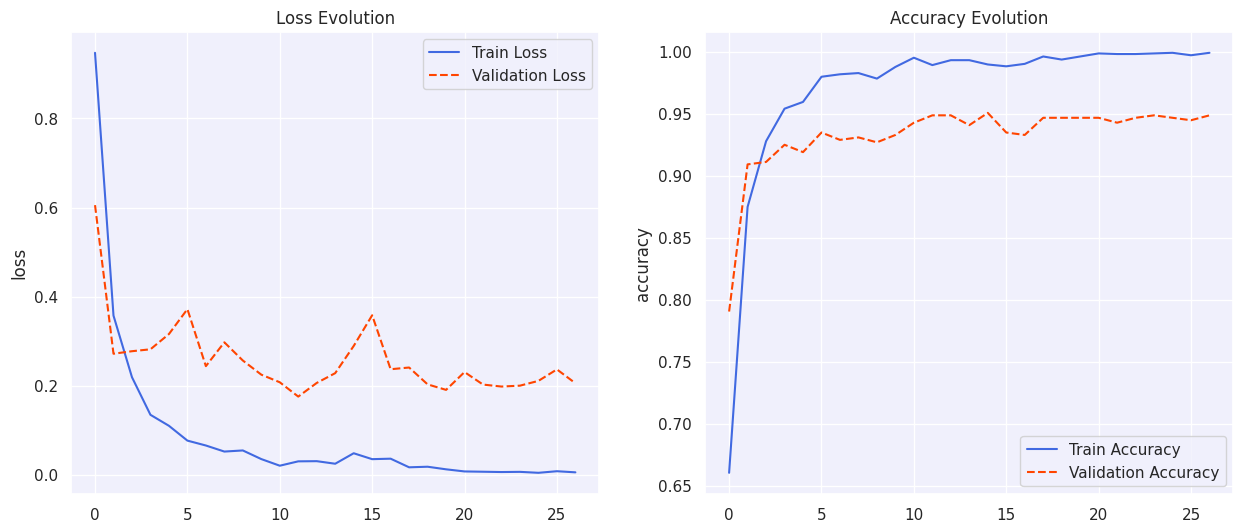

In [32]:
plot_learning_curves(history, start_epoch=1)

### Fine-Tuned ResNet50 Observations:
1. **Loss Evalution**:
   - **Train Loss**: Rapidly decreases and stabilizes after around 10 epochs.
   - **Validation Loss**: Starts off high but quickly converges to a lower value.

2. **Accuracy Evalution**:
   - **Train Accuracy**: Rapid ascent, approaching 100%. This demonstrates the model's capability to adapt quickly to the training data.
   - **Validation Accuracy**: Impressive progress, reaching around 96% in just a few epochs and maintaining that level. 

#### Inference:

The fine-tuned ResNet50 benefits from previous learnings, allowing for rapid convergence and a commendable validation **accuracy of 96%** within a few epochs.

### Step 5.4.2: Performance Metrics Assessment

In [33]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.
    
    Returns:
    - report: Classification report as a string.
    """
    
    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model  
    predictions = model.predict(val_generator, steps=len(val_generator))
    
    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')
    
    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step
              precision    recall  f1-score   support

   cardboard       0.97      0.95      0.96        81
       glass       0.96      0.93      0.94       100
       metal       0.99      0.98      0.98        82
       paper       0.93      0.97      0.95       119
     plastic       0.94      0.94      0.94        97
       trash       0.83      0.89      0.86        27

    accuracy                           0.95       506
   macro avg       0.94      0.94      0.94       506
weighted avg       0.95      0.95      0.95       506





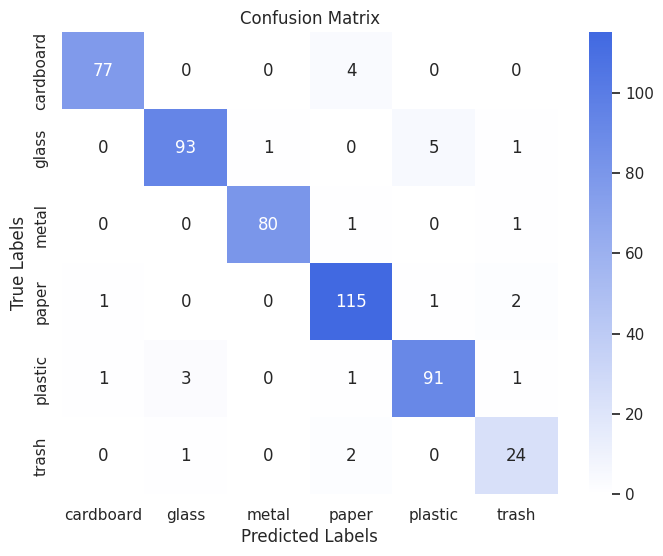

In [34]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)

### Model Performance Inferences:

1. **Overall Accuracy**: The model boasts an impressive accuracy of **94%**.
2. **Weighted Avg. F1 score** : **95%**
3. **Cardboard**,  **Glass**, **Metal**, **Paper**, and **Plastic** are standout performers, demonstrating near-perfect results.
4.  **Trash** also put up strong performances, with both precision and recall being commendable.
5.  Consistent F1-scores across categories highlight the model's reliability in making balanced predictions.

# Load the Saved Model

In [35]:
from tensorflow import keras

model = keras.models.load_model("best_garbage_model.h5")

In [36]:
# model input shape
print(model.input_shape)

(None, 384, 384, 3)


# Testing Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


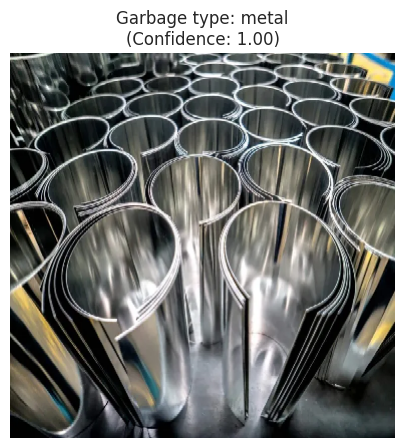

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


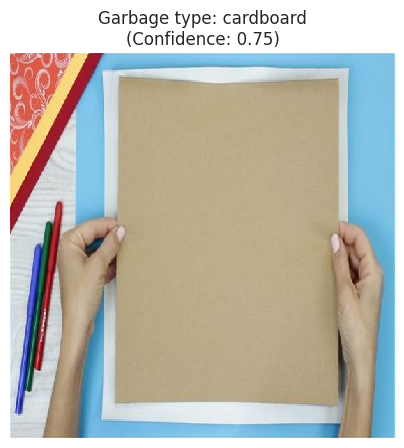

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


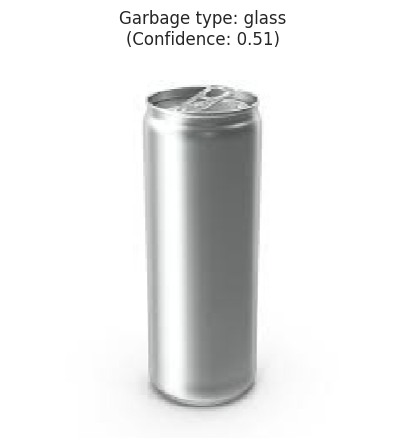

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


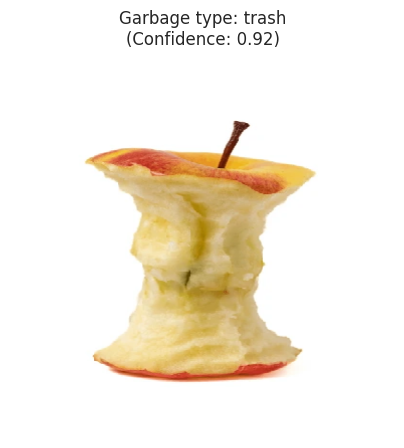

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


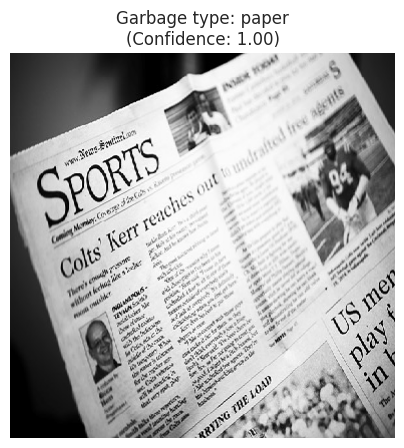

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


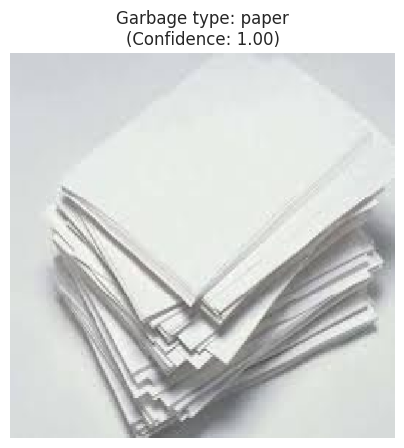

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


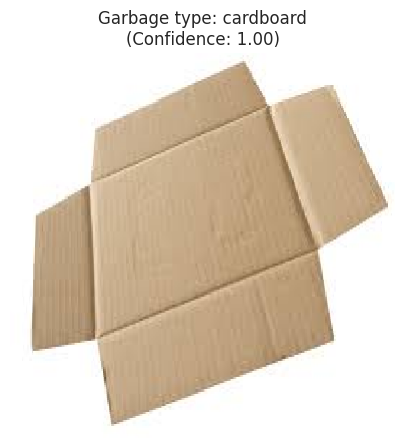

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


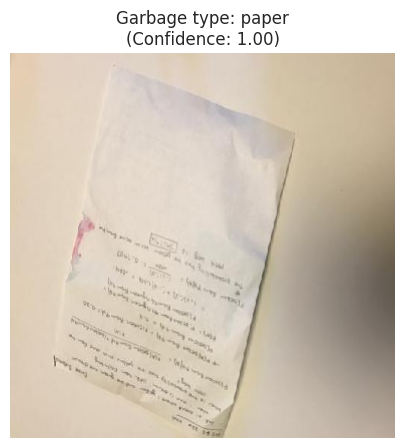

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


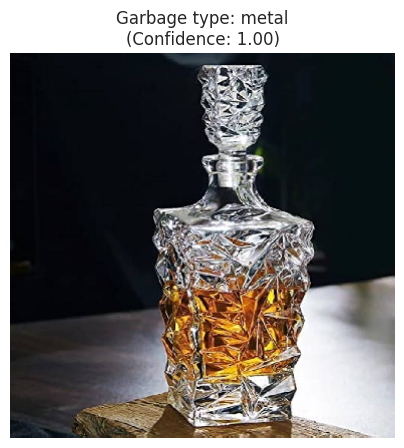

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


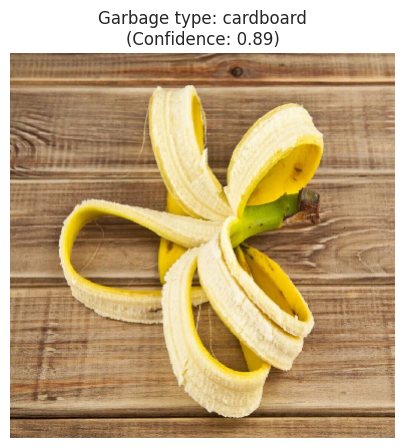

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


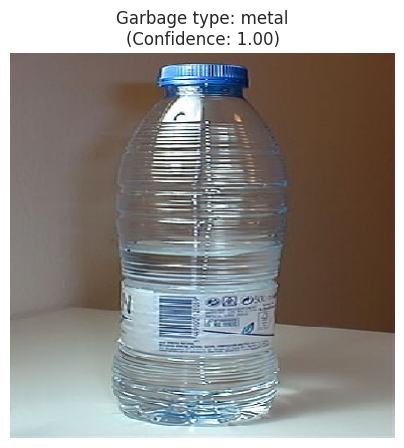

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


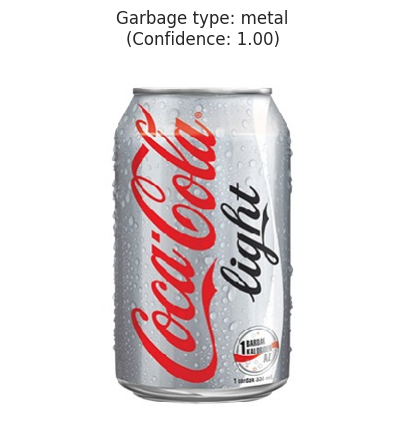

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


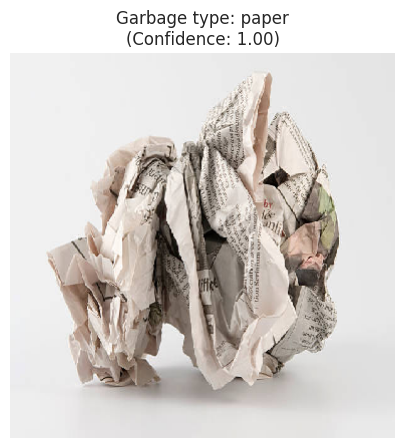

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


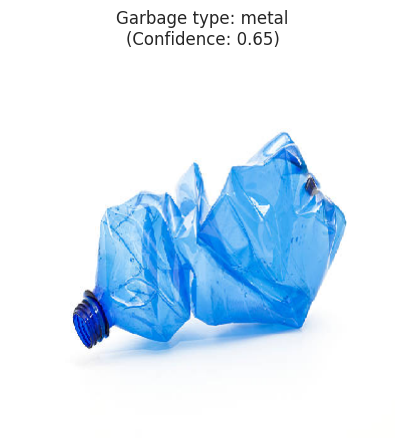

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


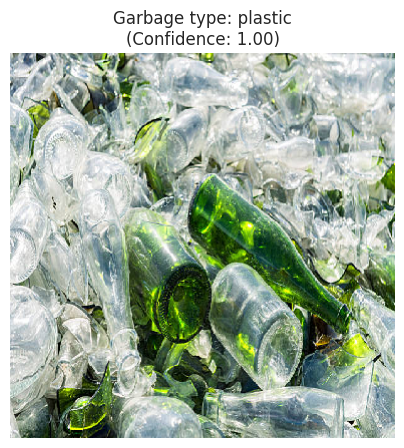

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


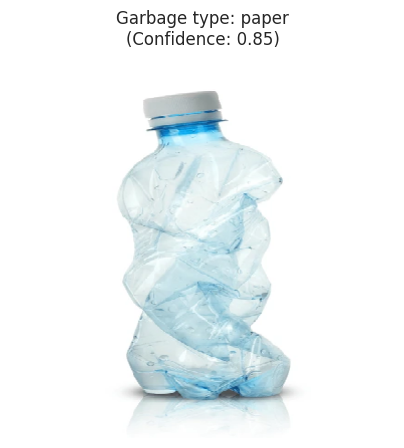

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


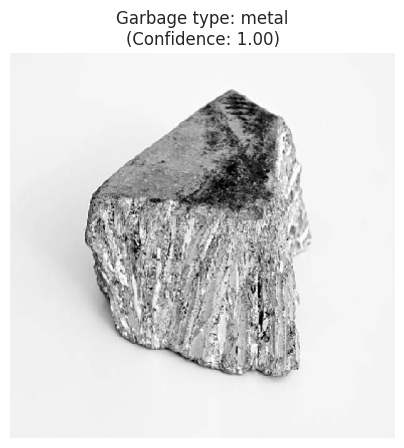

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input  # <-- ADD THIS

# Load model
model = load_model("best_garbage_model.h5")

# classes (same order as training generator)
class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Folder containing test images
folder_path = "/kaggle/input/garbage-test-images"

# Function to predict and return label + confidence score
def predict_img(img_path):
    img = load_img(img_path, target_size=(384, 384))   # ResNet input size
    img_array = img_to_array(img)

    # Correct preprocessing for ResNet (no /255)
    img_array = preprocess_input(img_array)

    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array)
    class_index = np.argmax(preds)
    confidence = preds[0][class_index]

    return class_names[class_index], confidence

# Loop through all images and display predictions
for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):

        img_path = os.path.join(folder_path, filename)

        label, conf = predict_img(img_path)

        img = load_img(img_path, target_size=(384, 384))

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Garbage type: {label}\n(Confidence: {conf:.2f})", fontsize=12)
        plt.show()
